<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/Forex_macro_corelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


Indicator: CPIAUCSL
Number of bins: 7, Number of labels: 6
              change              category
date                                      
2000-01-01       NaN                   NaN
2000-02-01  0.004135  Significant Increase
2000-03-01  0.005882  Significant Increase
2000-04-01 -0.000585     Moderate Decrease
2000-05-01  0.001755             No Change


Indicator: UNRATE
Number of bins: 7, Number of labels: 6
              change              category
date                                      
2000-01-01       NaN                   NaN
2000-02-01  0.025000  Significant Increase
2000-03-01 -0.024390     Moderate Decrease
2000-04-01 -0.050000     Moderate Decrease
2000-05-01  0.052632  Significant Increase


Indicator: GDP
Number of bins: 7, Number of labels: 6
              change           category
date                                   
2000-01-01       NaN                NaN
2000-04-01  0.024549         Category 6
2000-07-01  0.006874  Moderate Decrease
2000-10-01  0.011395    

<ipython-input-3-6fde635d9591>:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_reactions = merged_data.groupby('category')[time_frame].mean().reset_index()
<ipython-input-3-6fde635d9591>:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_reactions = merged_data.groupby('category')[time_frame].mean().reset_index()
<ipython-input-3-6fde635d9591>:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  catego

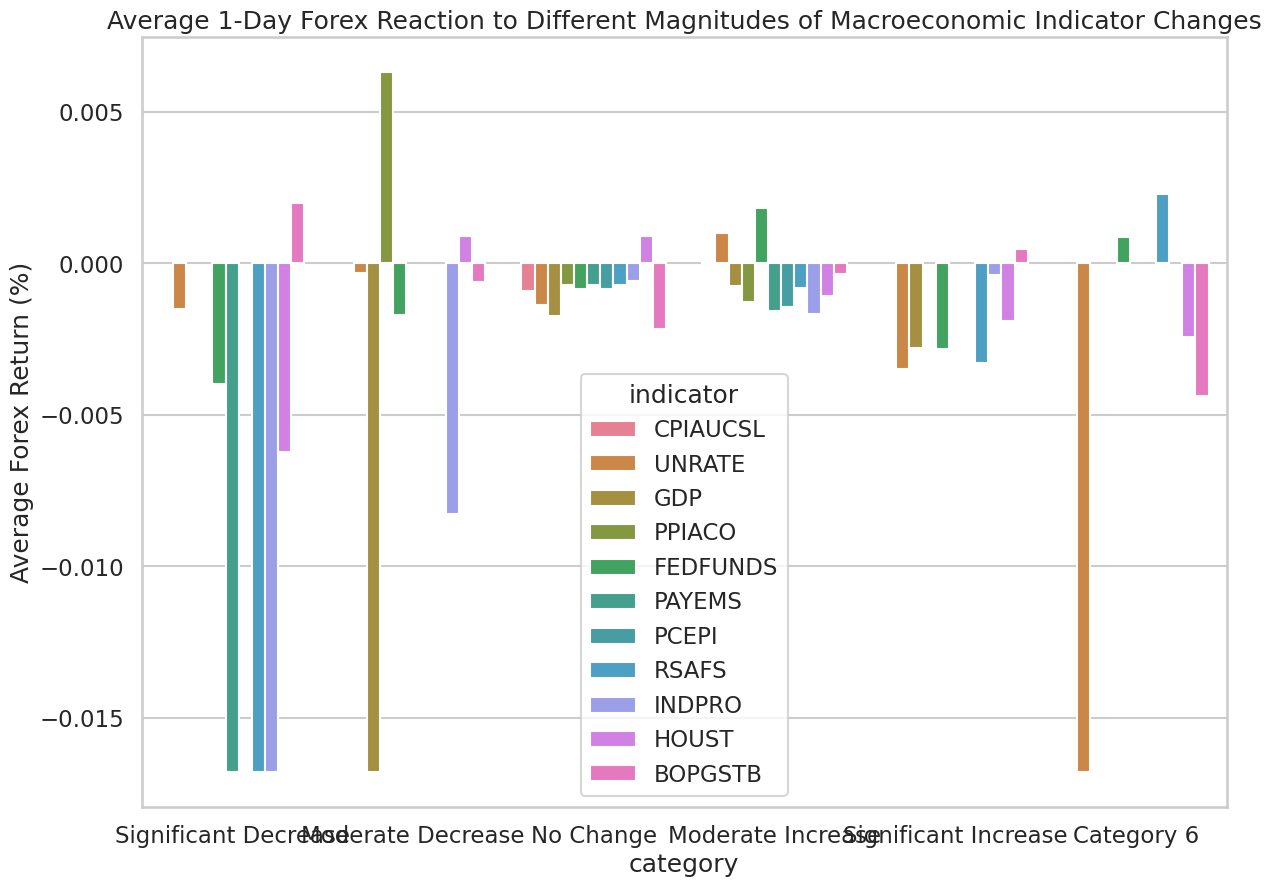

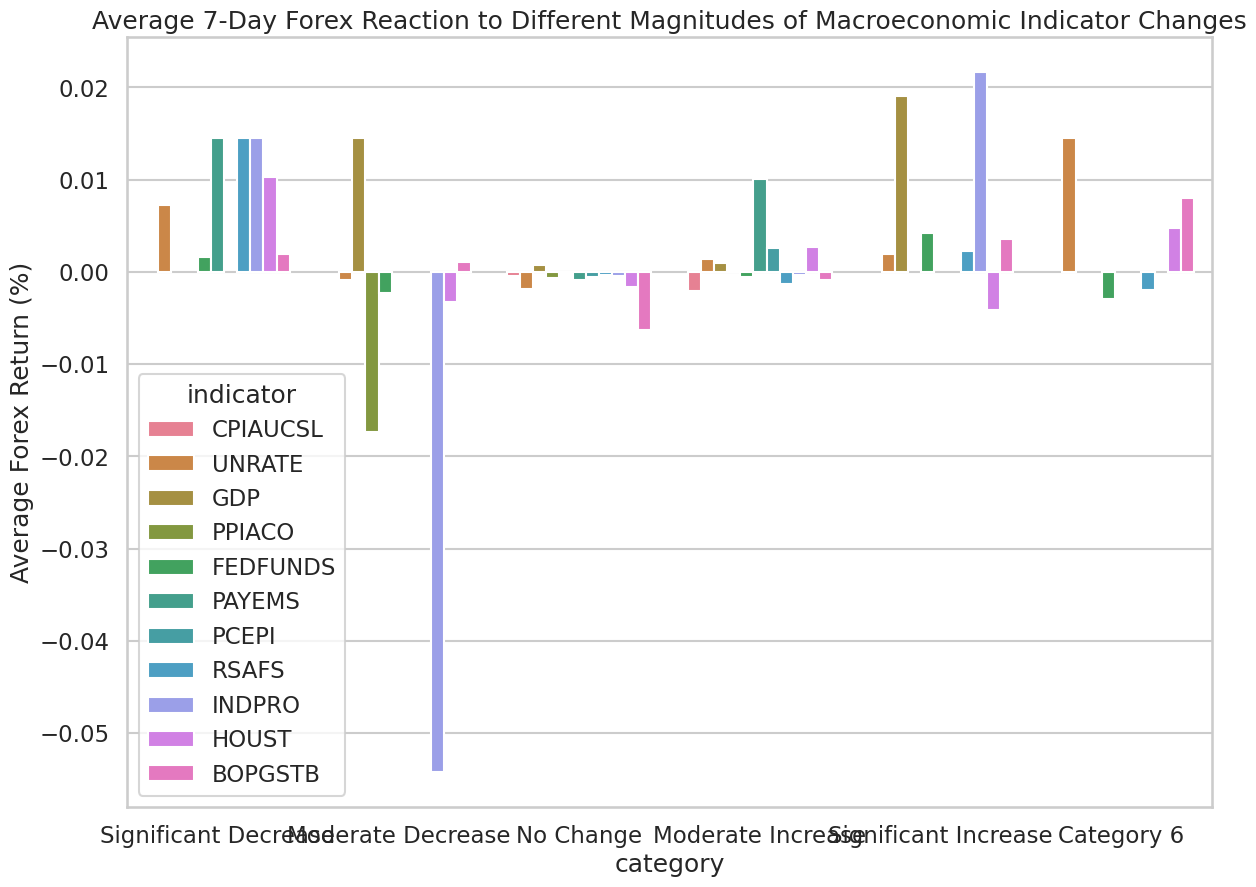

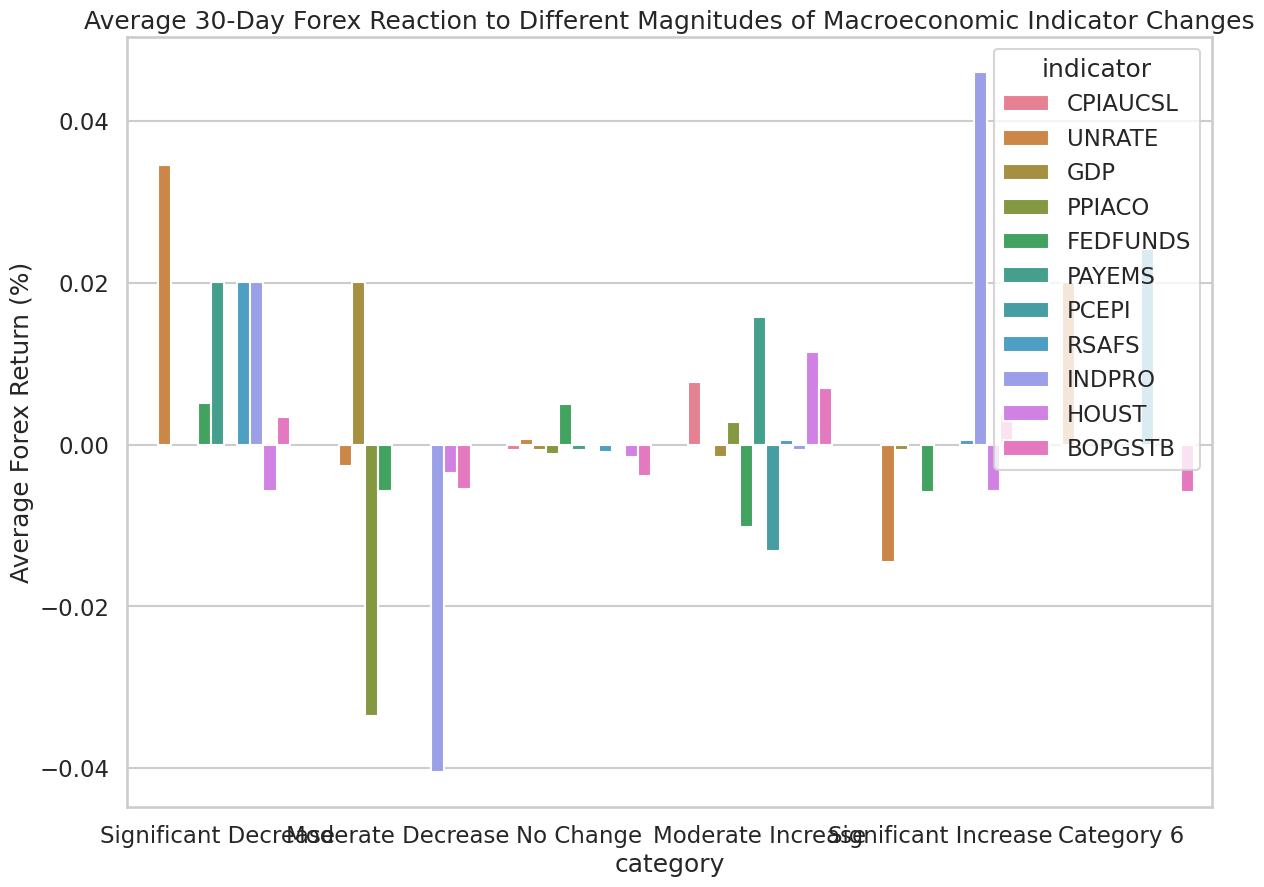

<ipython-input-3-6fde635d9591>:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = reaction_df.groupby(['indicator', 'category', 'time_frame']).agg(


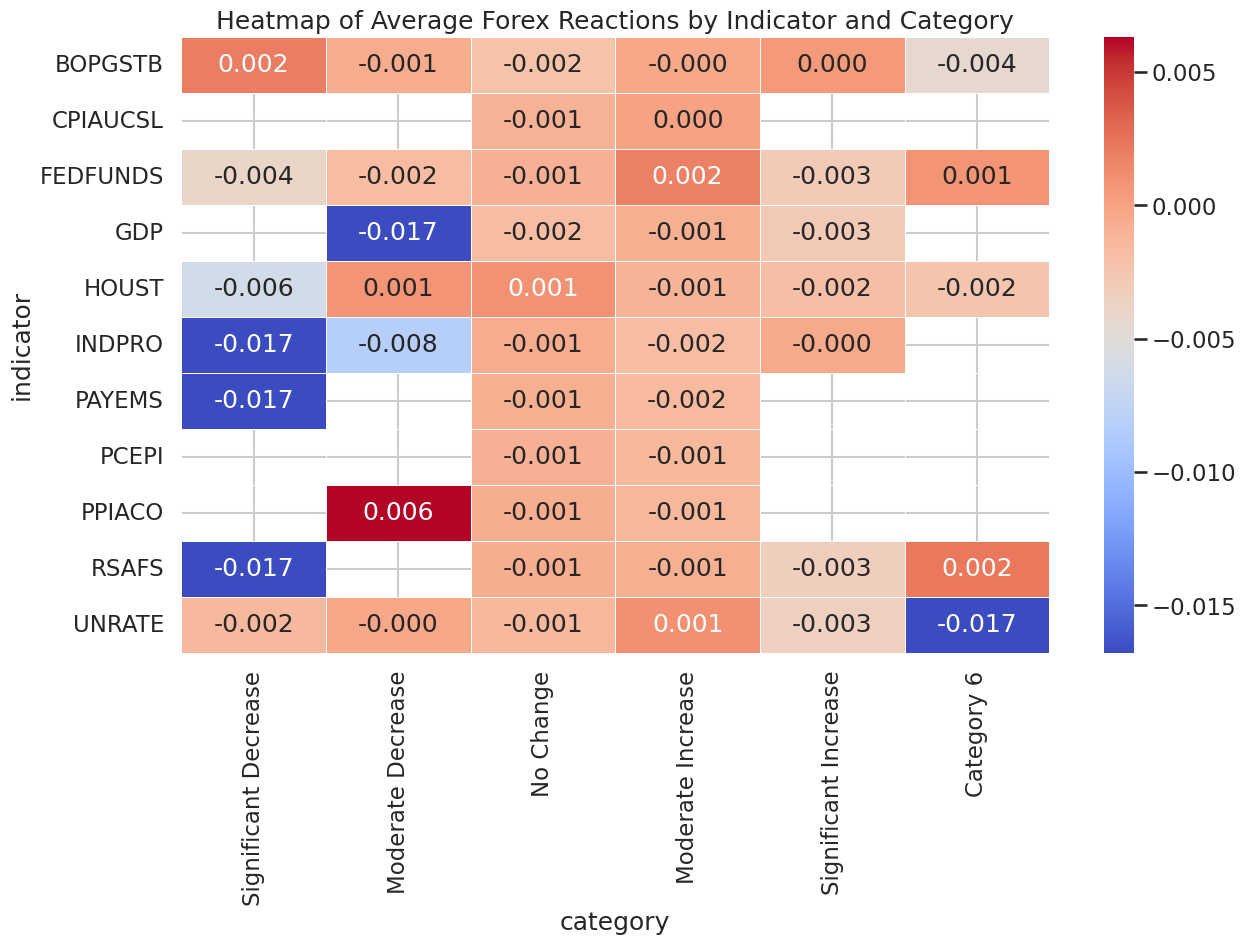

Regression Model for GDP vs. Forex Change:
Slope: -0.00876, Intercept: -0.00087, R^2: 0.010, p-value: 0.2249


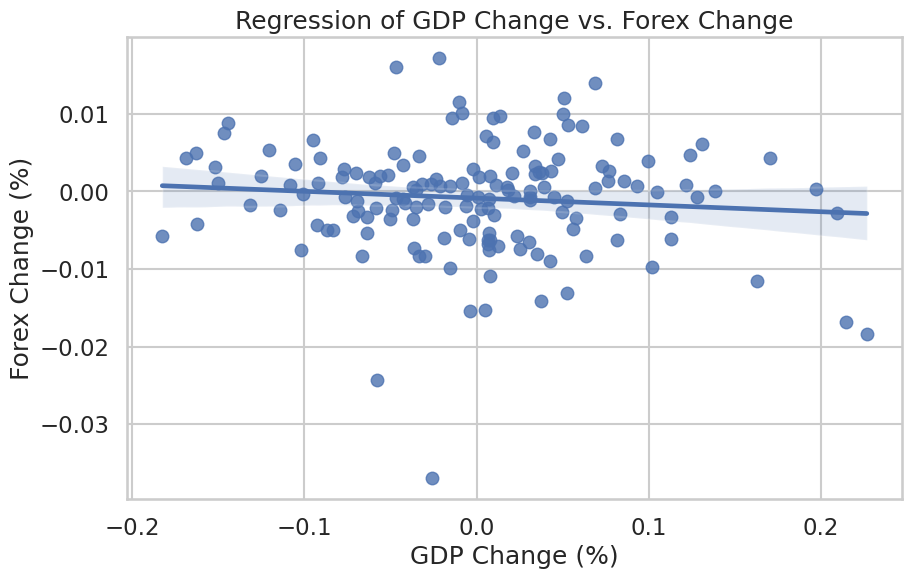

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import requests
import yfinance as yf

# Enhanced visualization settings
sns.set(style="whitegrid", context="talk")

# Function to download macroeconomic data from FRED
def download_fred_data(series_id, api_key):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if 'observations' in data:
            observations = data['observations']
            df = pd.DataFrame(observations)
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df[series_id] = pd.to_numeric(df['value'].str.replace(',', ''), errors='coerce')
            df.drop(columns=['value', 'realtime_start', 'realtime_end'], inplace=True)
            return df
        else:
            print(f"Error: 'observations' key not found in response for {series_id}. Check API response.")
            return None
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")
    return None

# Use your FRED API key
fred_api_key = 'xx'

# Download NQ data
forex_data = yf.download('NZDCAD=X', start='2006-01-01', end='2024-08-07', interval='1d')
forex_data['forex_change'] = forex_data['Close'].pct_change()
forex_data['7d_reaction'] = forex_data['forex_change'].rolling(window=7).sum().shift(-7)
forex_data['30d_reaction'] = forex_data['forex_change'].rolling(window=30).sum().shift(-30)

# Define macroeconomic indicators
macro_indicators = ['CPIAUCSL', 'UNRATE', 'GDP', 'PPIACO', 'FEDFUNDS', 'PAYEMS', 'PCEPI', 'RSAFS', 'INDPRO', 'HOUST', 'BOPGSTB']

# Dictionary to store thresholds for each indicator
thresholds_summary = {}

# Dictionary to store slope values
slope_summary = {}

# Calculate thresholds and slopes for each indicator
for indicator in macro_indicators:
    macro_data = download_fred_data(indicator, fred_api_key)
    if macro_data is not None:
        macro_data = macro_data[macro_data.index >= '2000-01-01']
        macro_data['change'] = macro_data[indicator].pct_change()

        # Calculate quantiles
        thresholds = {
            'significant_increase': macro_data['change'].quantile(0.95),
            'moderate_increase': macro_data['change'].quantile(0.75),
            'no_change': macro_data['change'].quantile(0.50),
            'moderate_decrease': macro_data['change'].quantile(0.25),
            'significant_decrease': macro_data['change'].quantile(0.05)
        }

        # Ensure thresholds are unique and sorted
        unique_thresholds = sorted(set(thresholds.values()))

        # Create bins and labels
        bins = [-np.inf] + unique_thresholds + [np.inf]
        labels = ['Significant Decrease', 'Moderate Decrease', 'No Change', 'Moderate Increase', 'Significant Increase']

        # Adjust the number of labels to match the number of bins
        if len(bins) - 1 < len(labels):
            labels = labels[:len(bins)-1]
        elif len(bins) - 1 > len(labels):
            labels = labels + ['Category ' + str(i) for i in range(len(labels)+1, len(bins))]

        thresholds_summary[indicator] = thresholds

        # Apply binning
        macro_data['category'] = pd.cut(macro_data['change'], bins=bins, labels=labels)

        # Perform regression analysis to find the slope
        aligned_data = pd.merge(macro_data[['change']], forex_data[['forex_change']], left_index=True, right_index=True)
        x = aligned_data['change'].dropna()  # Macroeconomic indicator changes (independent variable)
        y = aligned_data['forex_change'].dropna()  # NQ changes (dependent variable)

        if not x.empty and not y.empty:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            slope_summary[indicator] = slope

        # Visualize the categories for verification
        print(f"Indicator: {indicator}")
        print(f"Number of bins: {len(bins)}, Number of labels: {len(labels)}")
        print(macro_data[['change', 'category']].head())
        print("\n")

# Display slope values for each indicator
print("Slope values (NQ reaction to each indicator):")
for indicator, slope in slope_summary.items():
    print(f"{indicator}: {slope:.5f}")

# Placeholder for all reaction data
all_reactions = []

# Analyze Forex reactions
for indicator in macro_indicators:
    macro_data = download_fred_data(indicator, fred_api_key)
    if macro_data is not None:
        macro_data = macro_data[macro_data.index >= '2000-01-01']
        macro_data['change'] = macro_data[indicator].pct_change()

        dynamic_thresholds = thresholds_summary[indicator]

        macro_data['category'] = pd.cut(macro_data['change'],
                                        bins=bins, labels=labels)

        # Merge macroeconomic data with Forex data
        merged_data = pd.merge(macro_data[['change', 'category']], forex_data[['forex_change', '7d_reaction', '30d_reaction']],
                               left_index=True, right_index=True, how='inner')

        # Record reactions
        for time_frame in ['forex_change', '7d_reaction', '30d_reaction']:
            category_reactions = merged_data.groupby('category')[time_frame].mean().reset_index()
            category_reactions['indicator'] = indicator
            category_reactions['time_frame'] = time_frame
            all_reactions.append(category_reactions)

# Combine all reactions into a single DataFrame
reaction_df = pd.concat(all_reactions, ignore_index=True)

# Plot average forex reactions by category
plt.figure(figsize=(14, 10))
sns.barplot(x='category', y='forex_change', hue='indicator', data=reaction_df[reaction_df['time_frame'] == 'forex_change'])
plt.title('Average 1-Day Forex Reaction to Different Magnitudes of Macroeconomic Indicator Changes')
plt.ylabel('Average Forex Return (%)')
plt.show()

# Plot 7-day and 30-day reactions similarly
plt.figure(figsize=(14, 10))
sns.barplot(x='category', y='7d_reaction', hue='indicator', data=reaction_df[reaction_df['time_frame'] == '7d_reaction'])
plt.title('Average 7-Day Forex Reaction to Different Magnitudes of Macroeconomic Indicator Changes')
plt.ylabel('Average Forex Return (%)')
plt.show()

plt.figure(figsize=(14, 10))
sns.barplot(x='category', y='30d_reaction', hue='indicator', data=reaction_df[reaction_df['time_frame'] == '30d_reaction'])
plt.title('Average 30-Day Forex Reaction to Different Magnitudes of Macroeconomic Indicator Changes')
plt.ylabel('Average Forex Return (%)')
plt.show()

# Statistical Summary
summary_stats = reaction_df.groupby(['indicator', 'category', 'time_frame']).agg(
    mean_reaction=pd.NamedAgg(column='forex_change', aggfunc='mean'),
    median_reaction=pd.NamedAgg(column='forex_change', aggfunc='median'),
    stddev_reaction=pd.NamedAgg(column='forex_change', aggfunc='std')
).reset_index()

# Visualizing the Statistical Summary with heatmap
plt.figure(figsize=(14, 8))
summary_pivot = summary_stats.pivot_table(index='indicator', columns='category', values='mean_reaction')
sns.heatmap(summary_pivot, annot=True, cmap='coolwarm', fmt='.3f', linewidths=.5)
plt.title('Heatmap of Average Forex Reactions by Indicator and Category')
plt.show()

# Regression Analysis Example - GDP vs. Forex Change
aligned_data = merged_data.dropna(subset=['change', 'forex_change'])

x = aligned_data['change']
y = aligned_data['forex_change']

# Perform the regression analysis
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"Regression Model for GDP vs. Forex Change:\nSlope: {slope:.5f}, Intercept: {intercept:.5f}, R^2: {r_value**2:.3f}, p-value: {p_value:.4f}")

# Plot the regression
plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y)
plt.title('Regression of GDP Change vs. Forex Change')
plt.xlabel('GDP Change (%)')
plt.ylabel('Forex Change (%)')
plt.show()
